# Step 7 - Towards Cokriging

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import spatial

In [2]:
domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")
variogram_fit = pd.read_csv("variogram_fit.csv")
range_ = variogram_fit.iloc[0][0]
sill = variogram_fit.iloc[0][1]
nugget = 5 # have to figure out a real way to do this

In [3]:
def gaussian_variogram_model(d, parameters):
    range_=parameters[0]
    sill=parameters[1]
    nugget=parameters[2]
    psill =sill-nugget
    gamma = psill * (1. - np.exp(-d**2./(range_)**2.))+nugget
    return gamma

In [4]:
def exponential_variogram_model(d, range_, sill, nugget):
    psill =sill-nugget
    gamma = psill * (1. - np.exp(-d/(range_)))+nugget
    return gamma

In [5]:
def spherical_variogram_model(h, range_, sill, nugget):
    psill =sill-nugget
    gamma = np.zeros(len(h))
    for i in range(len(h)):
        if 0 <= abs(h[i]) <= range_:
            gamma[i] = psill * ((3/2*abs(h[i])/range_)-(1/2*(abs(h[i])/range_)**3))+nugget
        else:
            gamma[i] = psill + nugget
    return gamma

In [6]:
h = np.arange(0, 2000, 0.1)
range_ = 400
sill = 40
nugget = 10

(0, 41.5)

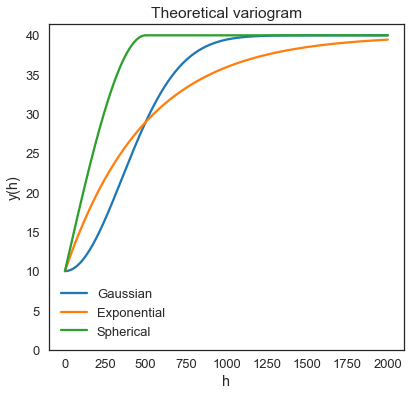

In [7]:
figure = plt.figure(figsize=(14,6))

ax1 = figure.add_subplot(1,2,1)
ax1.set_xlabel("h")
ax1.set_ylabel("y(h)")
ax1.set_title('Theoretical variogram')
ax1.plot(h, gaussian_variogram_model(h, (500, 40, 10)),'-',label='Gaussian')
ax1.plot(h, exponential_variogram_model(h, 500, 40, 10),'-',label='Exponential')
ax1.plot(h, spherical_variogram_model(h, 500, 40, 10),'-',label='Spherical')
ax1.legend(loc ='best')
ax1.set_ylim(0)

(0, 50)

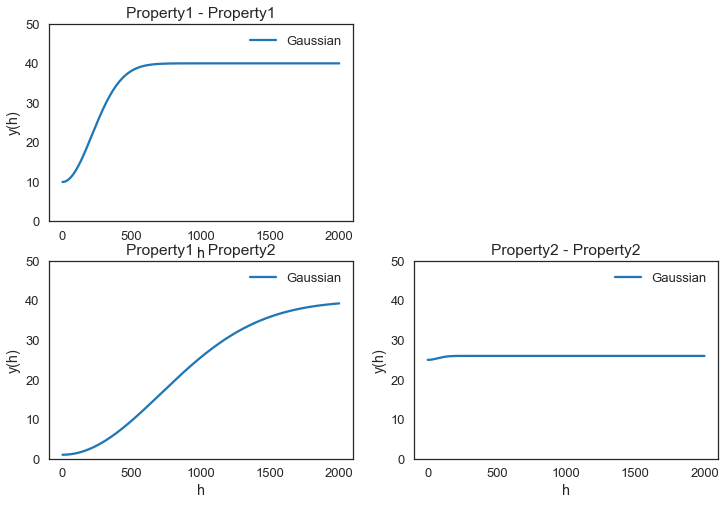

In [8]:
figure = plt.figure(figsize=(12,8))

ax1 = figure.add_subplot(2,2,1)
ax1.set_xlabel("h")
ax1.set_ylabel("y(h)")
ax1.set_title('Property1 - Property1')
ax1.plot(h, gaussian_variogram_model(h, (300, 40, 10)),'-',label='Gaussian')
ax1.legend(loc ='best')
ax1.set_ylim(0,50)

ax2 = figure.add_subplot(2,2,3)
ax2.set_xlabel("h")
ax2.set_ylabel("y(h)")
ax2.set_title('Property1 - Property2')
ax2.plot(h, gaussian_variogram_model(h, (1000, 40, 1)),'-',label='Gaussian')
ax2.legend(loc ='best')
ax2.set_ylim(0,50)

ax2 = figure.add_subplot(2,2,4)
ax2.set_xlabel("h")
ax2.set_ylabel("y(h)")
ax2.set_title('Property2 - Property2')
ax2.plot(h, gaussian_variogram_model(h, (100, 26, 25)),'-',label='Gaussian')
ax2.legend(loc ='best')
ax2.set_ylim(0,50)

In [9]:
def create_synthetic_Input_data(n_samples, grid, mean1, std1, mean2, std2):
    '''
    This Part is used to create synthetic Input data. It is possible to vary the number of properties
    and the number of samples. Right now every assigned value is a random value between 0 and 100.
    Data is thus in no way spatially correlated, which makes the Kriging kind of useless, but works for
    testing purposes. Only an isotopic case is realized. Max 10 properties can be used due to a.
    Args: 
        n_prop (int): Number of properties that we have data for
        n_samples (int): Number of sample locations, were we have data for every property (isotopic)
        grid (pandas.dataframe): grid from which the coordinates for the data points are taken
    Returns:
        df_prop(pandas.dataframe): dataframe containing x,y,z coordinates and data for n properties
    '''
    # this case only for one property
    n_prop = 2
    # copy to leave original grid intact
    data_loc_aux = grid.copy()

    # create dataframe with coordinates and n properties
    d = ['X', 'Y', 'Z', 'Property1', 'Property2']
    df_prop = pd.DataFrame(columns=d)
    
    for i in range(n_samples):
            # choose random point from df_sgs_grid_calc
            rand_pos = np.random.randint(0,len(data_loc_aux))
            random_coord = np.array([data_loc_aux.loc[rand_pos,'X'],data_loc_aux.loc[rand_pos,'Y'],data_loc_aux.loc[rand_pos,'Z']])
            
            # delete point from the df sgs_grid_calc
            data_loc_aux = data_loc_aux.drop([rand_pos])
            data_loc_aux = data_loc_aux.reset_index() # reset indicies
            del data_loc_aux['index'] #reset indices
            
            # pick random coordinate from grid
            data_point=([random_coord[0], random_coord[1], random_coord[2]])
            data_point_aux = np.array([data_point])
            
            if df_prop.empty:
                # create starting point
                data_values = np.array([np.random.normal(mean1, scale=std1), np.random.normal(mean2, scale=std2)])
                print(data_values)
            else:
                # create a value based on covariance function
                # mean, std = kriging()
                # only select n closest points for Cokriging,best by selection to make it work with miguels code
                df_prop_calc_close = select_closest_points(data_point_aux, df_prop)
                data_values = ordinary_cokriging(data_point, df_prop_calc_close)
            
            # add calculated data value
            data_point.append(data_values[0])
            data_point.append(data_values[1])
        
            # put it into the dataframe
            df_prop.loc[i]=data_point

    return df_prop

In [10]:
def select_closest_points(coordinate, data, n=50):
    """
    Method to select n closest points from the given coordinate to perform Cokriging with reasonable calculation
    time
    Args:
        coord (np.array): coordinates of point
        df (pandas.dataframe): dataframe containing coordinated and properties
    Returns
        df_cut (pandas.dataframe): dataframe containing only the 50 closest points
    """
    data_aux1 = data.copy()
    data_aux2 = data.as_matrix(('X','Y','Z'))
    
    dist = spatial.distance.cdist(coordinate, data_aux2) 
    data_aux1 = data.copy()
    
    dist_aux = dist.flatten()
    data_aux1['dist']= pd.Series(dist_aux)

    closest_points = data_aux1.sort_values(by=['dist'])[:n]
    
    return closest_points

In [11]:
#OcK method, should be fine like this, starting for 2 properties, isotopic
def ordinary_cokriging(point, data):
    
    n_prop = 2
    
    data_m = data.as_matrix(('X','Y','Z'))
    data_v1 = data['Property1'].values
    data_v2 = data['Property2'].values
    
    # habe ich hier so nicht
    data_d = data['dist'].values #take dist from closest points selection
    
    shape = len(data_m)*n_prop
    
    # variogram matrix, containing parameters of for variogram and cross variogram function
    # in this case containing range, sill and nugget for a gaussian model
    p1p1 = np.array([300, 40, 10])
    p2p2 = np.array([100, 26, 25])
    p1p2 = np.array([1000, 40, 1])
    
    v2 = np.ndarray((3,3))
    v2[0]=p1p1
    v2[1]=p1p2
    v2[2]=p2p2
    
    #test for slicing algorithm
    v = np.array([[(p1p1),(p1p2)],[(p1p2) ,(p2p2)]])   
    
    #setting soze of matrices, added one length of n_prop for Ordinary Part only with weights
    # slicing doesnt work if its to big
    C = np.zeros((shape, shape))
    c = np.zeros((shape, n_prop)) 
    w = np.zeros((shape+n_prop, n_prop))
    
    # Faster matrix building approach, reduced  looping
    dist = spatial.distance.cdist(data_m, data_m) #distance between all sampled points
    
    #!!!!!
    # Matrix filling routine, best case use slices instead of other stuff
    
    for i in range (n_prop):
        for j in range (n_prop):
            C[i::n_prop,j::n_prop]=gaussian_variogram_model(dist, v[i, j]) 
            
    # additional matrices for Ordinary kriging and zeros
    aux1 = np.tile(np.eye(n_prop),(len(data_m), 1))
    aux2 = np.hstack((np.tile(np.eye(n_prop),(1,len(data_m))),np.zeros((n_prop,n_prop))))
    
    # add everything together to get Ordinary Cokriging Matrix
    C = np.hstack((C, aux1))
    C = np.vstack((C, aux2))
    
    # Major Mindfuck :) - now it works
    for i in range (n_prop):
        for j in range (n_prop):
            c[i::n_prop, j]=gaussian_variogram_model(data_d, v[i, j]) 

    # add everything together to get Ordinary Cokriging Matrix
    c = np.vstack((c, np.eye(n_prop)))

    '''
    # Main matrix C
    for pointX in range(len(data_m)):
        for pointY in range(len(data_m)):
            for i in range(n_prop):
                for j in range(n_prop):
                    C[pointX*n_prop+i, pointY*n_prop+j]=gaussian_variogram_model(dist[pointX,pointY],v[i+j])
    
    # Ordinary part at the sides
    pointX_aux = len(data_m) #maybe plus one
    for pointY_aux in range (len(data_m)):
        for i in range(n_prop):
                for j in range(n_prop):
                    C[pointX_aux*n_prop+i, pointY_aux*n_prop+j]=v_aux[i+j]
    
    # Ordinary part at the sides
    pointY_aux = len(data_m) #maybe plus one
    for pointX_aux in range (len(data_m)):
        for i in range(n_prop):
                for j in range(n_prop):
                    C[pointX_aux*n_prop+i, pointY_aux*n_prop+j]=v_aux[i+j]
    
    # Second Matrix c
    for point in range(len(data_m)):
        for i in range(n_prop):
            for j in range(n_prop):
                c[point*n_prop+i,j]=gaussian_variogram_model(data_d[point],v2[i+j])
    
    # Second Matrix Ordinary Part
    point_aux = len(data_m) #maybe plus one
    for i in range(n_prop):
        for j in range(n_prop):
            c[point_aux*n_prop+i,j]=v_aux[i+j]
    '''

    # Solve Kriging equations
    w = np.linalg.solve(C,c[:,0])
    w2 = np.linalg.solve(C,c[:,1])
    
    # for multiple results:
    results = np.zeros((n_prop))
    
    # SGS version - not correct yet, need to get mean and std
    #result = np.random.normal(np.sum(w[:shape] * data_v), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))
    
    # this is now only for exactly 2 properties
    # correct for negative weights (setting to zero and renormalize to one)
    w_aux1 = w[0:shape:2]
    w_aux1[w_aux1 < 0] = 0
    w_aux1 = w_aux1/sum(w_aux1)
    
    w_aux2 = w2[1:shape:2]
    w_aux2[w_aux2 < 0] = 0
    w_aux2 = w_aux2/sum(w_aux2)
    
    # direct version, calculating result from weights.
    #results[0] = np.sum(w_aux1 * data_v1)
    #results[0] = np.sum(w_aux2 * data_v2)
    
    results[0] = np.random.normal(np.sum(w_aux1 * data_v1),scale=5)
    results[1] = np.random.normal(np.sum(w_aux2 * data_v2),scale=5)
    
    return results

In [12]:
%%time
data = create_synthetic_Input_data(n_samples=3500, grid=domain, mean1=20, std1=5, mean2=20, std2=5)

[22.9733772  25.39642558]
Wall time: 31.4 s


In [13]:
# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

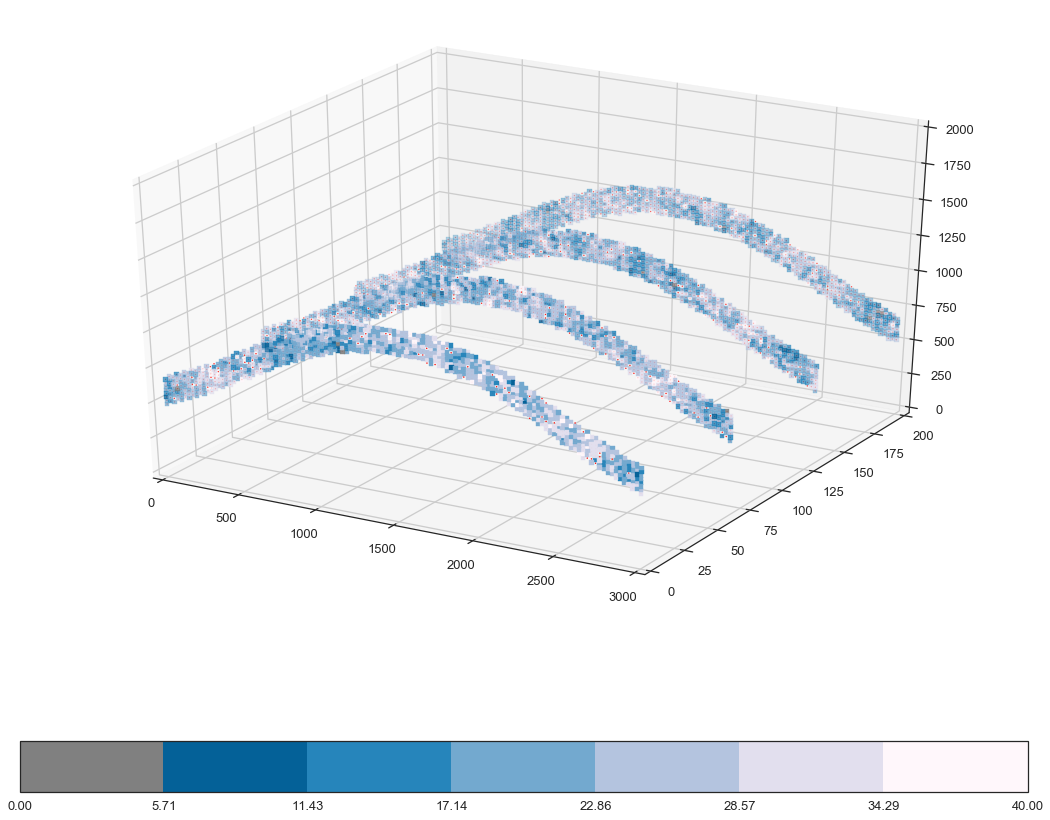

In [14]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)

a = ax.scatter3D(xs=domain.X,ys=domain.Y,zs=domain.Z, c='red', s=1)
b = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property1, s=20, marker=',', cmap=cmap, norm=norm)

fig.colorbar(b, orientation='horizontal')

In [15]:
results_f = data.loc[data['Y'] < 1]

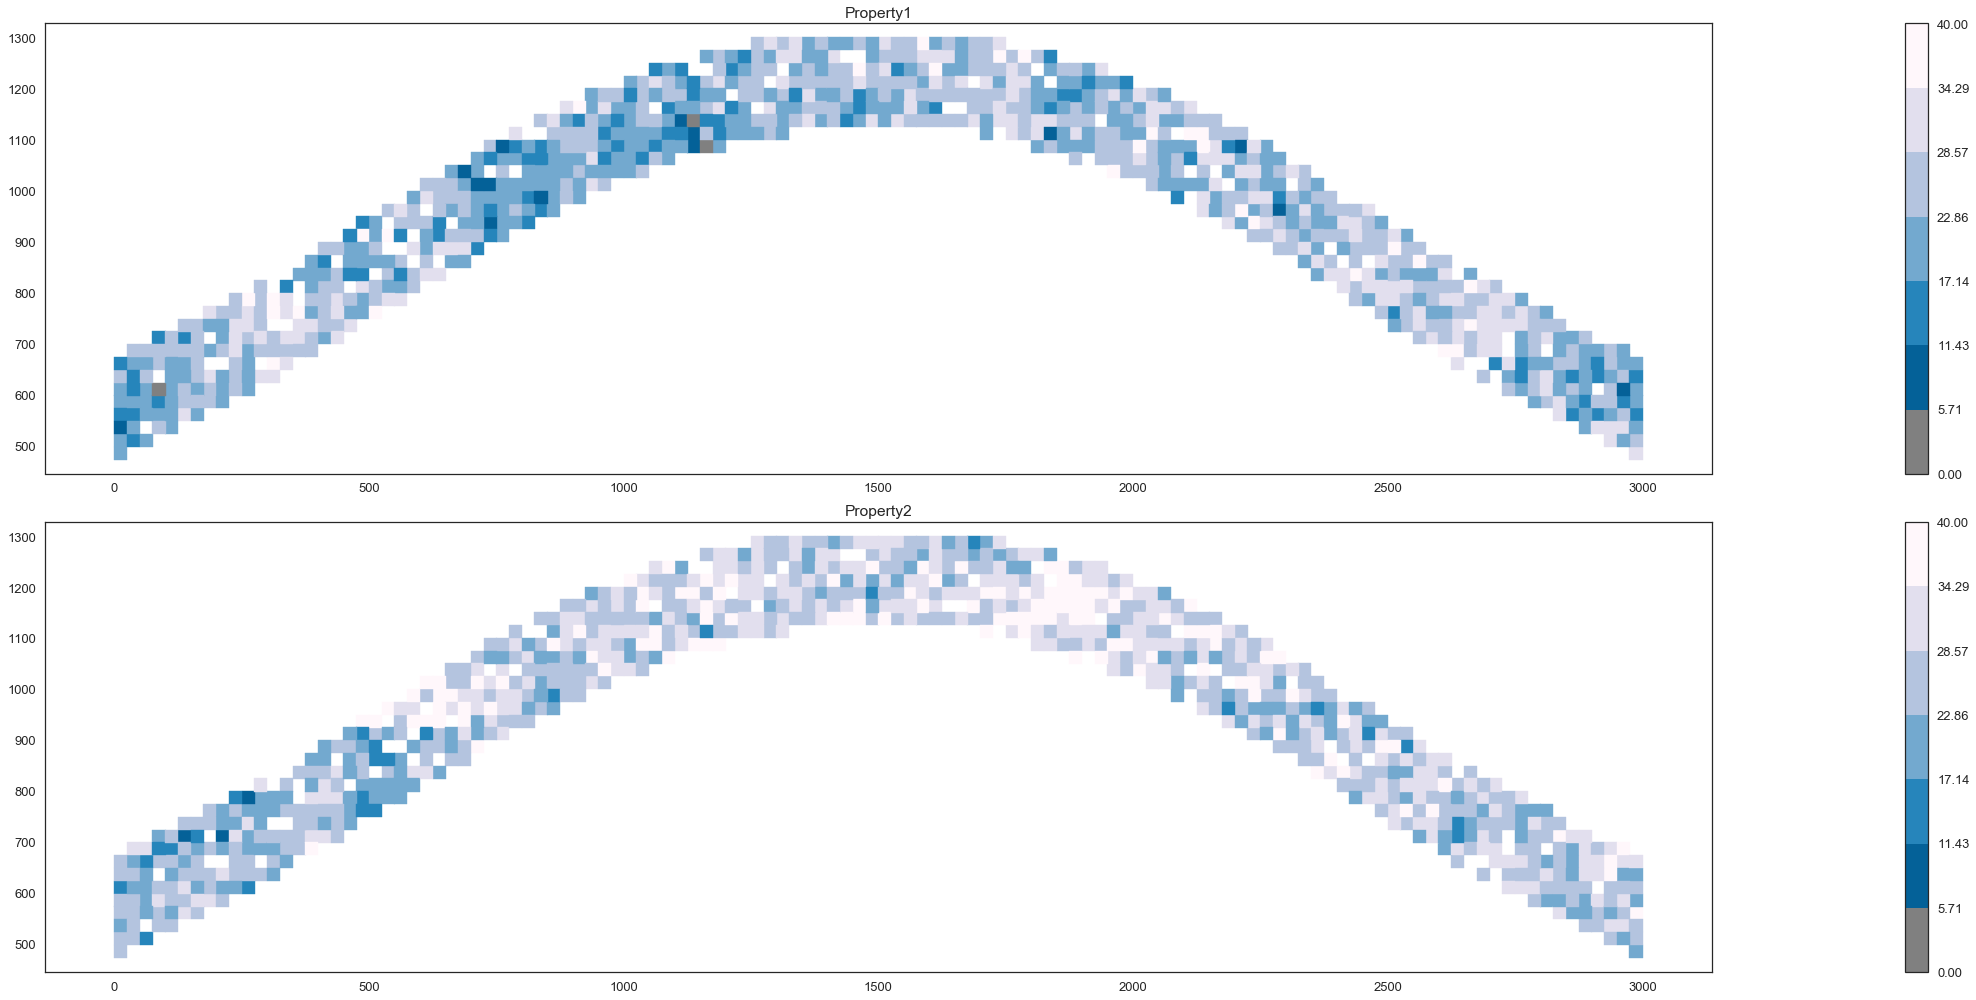

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(32,14))

img1 = ax1.scatter(results_f.X, results_f.Z, c=results_f.Property1, s=170, marker=',', cmap=cmap, norm=norm)
fig.colorbar(img1, ax=ax1)
ax1.set_aspect('auto')
ax1.axis('scaled')
ax1.set_title("Property1")

img2 = ax2.scatter(results_f.X, results_f.Z, c=results_f.Property2, s=170, marker=',', cmap=cmap, norm=norm)
fig.colorbar(img2, ax=ax2)
ax2.set_aspect('auto')
ax2.axis('scaled')
ax2.set_title("Property2")

plt.tight_layout(h_pad=1)

In [17]:
print(min(data['Property2'])) #damn negative values caused by high std of 5 ... should set those to 0

5.89541721478054


In [18]:
data.to_csv("data3d_2prop.csv", index=False)